In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import data_actions.data_processing.utils as utils

# Products data exploration for RecSys 2025

For the purpose of the efficiency and processing multiple datasets with millions of rows, we decided to use **Polars** instead of Pandas, because of its Lazy API, which enables us to better manage memory.


In [104]:
data_folder = "data/original_data"
data = utils.load_data(data_folder)

# File `product_properties`

First, lets take a look into basic products' statistics.
Each product have four attributes:
* sku (int64): numeric ID of the item
* category (int64): numeric ID of the item category
* price (int64): numeric ID of the item's price bucket, no the price itself
* name (object): a textual embedding of a product name, compressed using the product quantization method

In [105]:
products = data["products"]["product_properties"]
products.describe()

statistic,sku,category,price,name
str,f64,f64,f64,str
"""count""",1.197634e6,1.197634e6,1.197634e6,"""1197634"""
"""null_count""",0.0,0.0,0.0,"""0"""
"""mean""",748283.428842,3497.911358,47.466395,null
"""std""",431765.419146,1908.822438,27.894335,null
"""min""",0.0,0.0,0.0,"""[ 0 0 28 150 36 36 4 …"
"""25%""",374395.0,1902.0,24.0,null
"""50%""",748439.0,3378.0,45.0,null
"""75%""",1.12245e6,5131.0,71.0,null
"""max""",1.495777e6,6918.0,99.0,"""[99 76 14 39 39 96 73 96 39 39…"


There is $1197634$ different products in total, splitted into $6918$ categories, and $99$ price buckets.

## Categories

In [106]:
categories = products.group_by("category").agg(pl.len().alias("count")).collect()

In [107]:
categories = categories.sort(pl.col("category"))

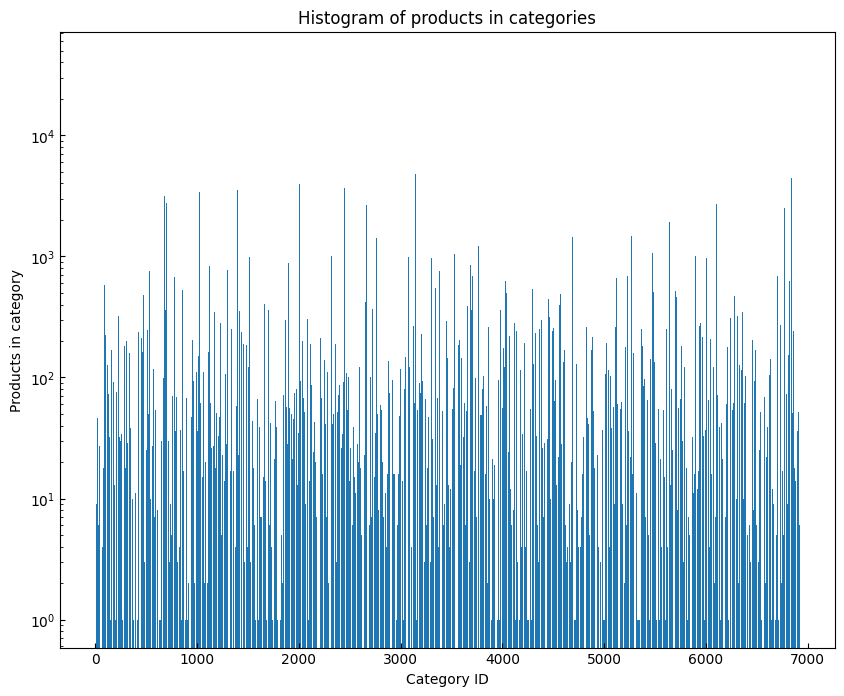

In [108]:
plt.figure(figsize = (10,8))
plt.bar(categories["category"], categories["count"])
plt.yscale("log")
plt.xlabel("Category ID")
plt.ylabel("Products in category")
plt.title("Histogram of products in categories")
ax = plt.gca()
ax.tick_params(direction="in", axis="both", which="both")
plt.show()

## Prices

In [109]:
prices = products.group_by("price").agg(pl.len().alias("count")).collect()

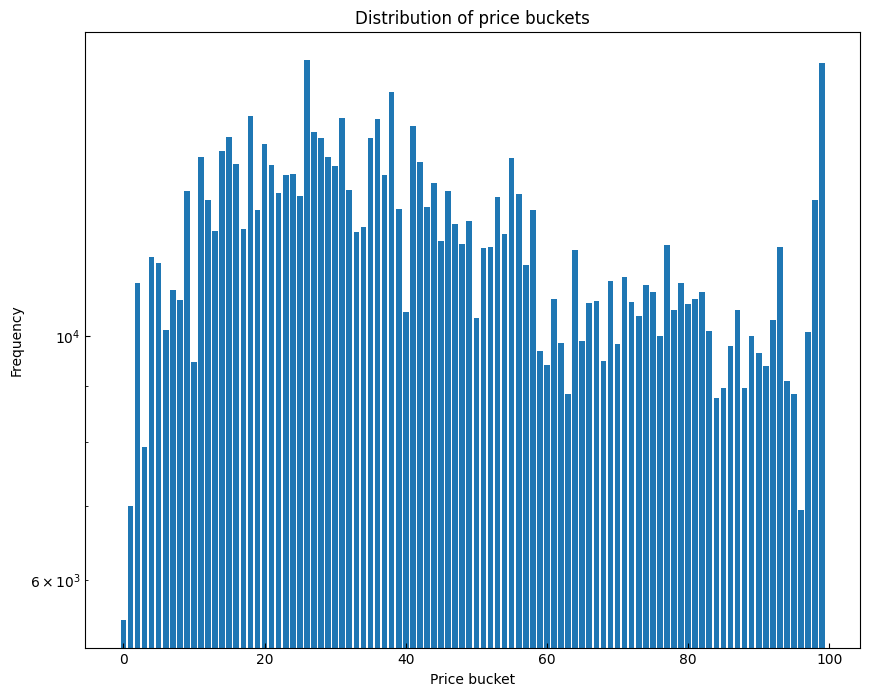

In [110]:
plt.figure(figsize = (10,8))
plt.bar(prices["price"], prices["count"])
plt.yscale("log")
plt.xlabel("Price bucket")
plt.ylabel("Frequency")
plt.title("Distribution of price buckets")
ax = plt.gca()
ax.tick_params(direction="in", axis="both", which="both")
plt.show()

In [111]:
df = products.select("category", "price").collect()
df.corr()

category,price
f64,f64
1.0,0.001637
0.001637,1.0


There is no correlation between product price and its category

# File `product_buy`

Now, take a look into sale of products
In this file, each record have three attribute
* `client_id` (int64): numeric ID of the client (system user)
* `timestamp` (object): date and time of the event in the format YYYY-MM-DD HH:mm:ss (not used in this EDA)
* `sku` (int64): numeric ID of the item


In [112]:
products_buy = data["events"]["product_buy"]
prices = products.group_by("sku").agg(pl.len().alias("count")).collect()

In [113]:
products_buy.describe()

statistic,client_id,timestamp,sku
str,f64,str,f64
"""count""",1.682296e6,"""1682296""",1.682296e6
"""null_count""",0.0,"""0""",0.0
"""mean""",1.1941e7,null,746549.671699
"""std""",6.8918e6,null,433618.826745
"""min""",14.0,"""2022-05-23 00:10:40""",4.0
"""25%""",5.964836e6,null,369890.0
"""50%""",1.1924383e7,null,745837.0
"""75%""",1.791873e7,null,1.121913e6
"""max""",2.3875234e7,"""2022-10-10 23:59:25""",1.495777e6


In [134]:
products_buy.select("sku").collect().unique().shape[0] / products.select("sku").collect().unique().shape[0]

0.4234240176882086

Group products to bin by: $\text{bin} = \lfloor \frac{\text{bought number}}{10}\rfloor$, for items that were never bought $\text{bin} = -1$

In [114]:
def assign_bin(value):
    if value == 0:
        return -1
    return value // 10

In [144]:
sku = products_buy.select("sku").collect()
# max_sku = products.select("sku").max().collect()[0, 0]
sku = sku.group_by("sku").agg(pl.len().alias("count"))
full_sku = products.select("sku").collect()
sku_full = pl.DataFrame({"sku": full_sku})
sku = sku_full.join(sku, on="sku", how="left").fill_null(0)

sku = sku.with_columns(
    (pl.col("count").map_elements(lambda x: assign_bin(x), return_dtype=pl.Int8)).alias("bin")  # Create a new column for bin numbers
)
sku_grouped = sku.group_by("bin").agg(pl.len().alias("frequency"))
sku_grouped = sku_grouped.sort(pl.col("bin"))

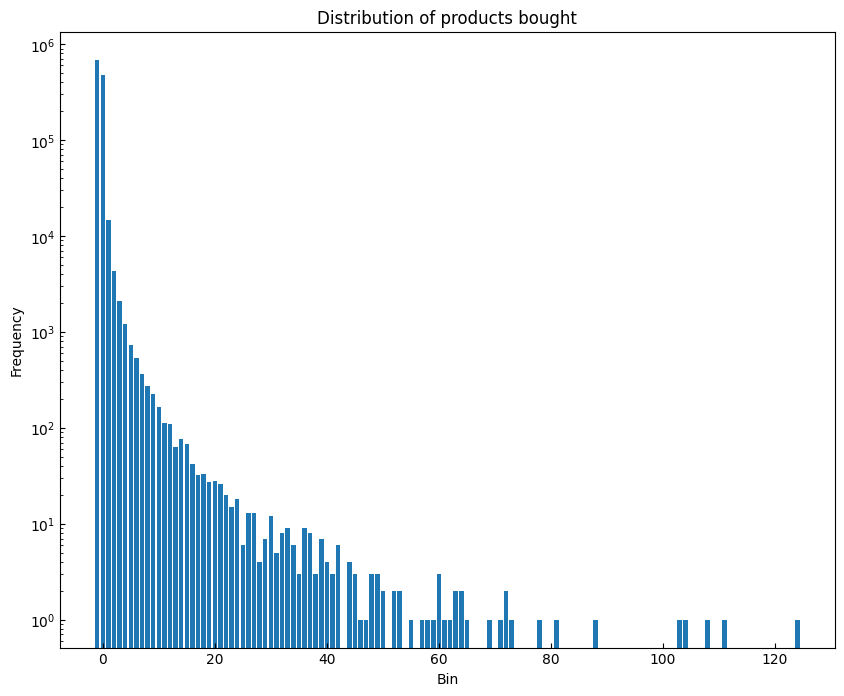

In [145]:
plt.figure(figsize = (10,8))
plt.bar(sku_grouped["bin"], sku_grouped["frequency"])
plt.yscale("log")
plt.xlabel("Bin")
plt.ylabel("Frequency")
plt.title("Distribution of products bought")
ax = plt.gca()
ax.tick_params(direction="in", axis="both", which="both")
plt.show()

From all available products, $57.6\%$ were never bought


In [146]:
sku_grouped["frequency"][0] / sku_grouped["frequency"].sum()

0.5765759823117914

In [153]:
thresholds = [200, 100, 50, 25, 10, 5, 1, 0]

for th in thresholds:
    vv = sku.filter(
        (pl.col("count") > th)
    )["count"].len() / sku["count"].len()

    print(f"{vv:.2%} were bought more than {th} times")

0.02% were bought more than 200 times
0.08% were bought more than 100 times
0.25% were bought more than 50 times
0.65% were bought more than 25 times
1.88% were bought more than 10 times
4.00% were bought more than 5 times
19.40% were bought more than 1 times
42.34% were bought more than 0 times


In [154]:
sku.describe()

statistic,sku,count,bin
str,f64,f64,f64
"""count""",1.197634e6,1.197634e6,1.197634e6
"""null_count""",0.0,0.0,0.0
"""mean""",748283.428842,1.404683,-0.520918
"""std""",431765.419146,7.878186,0.934094
"""min""",0.0,0.0,-1.0
"""25%""",374395.0,0.0,-1.0
"""50%""",748439.0,0.0,-1.0
"""75%""",1.12245e6,1.0,0.0
"""max""",1.495777e6,1249.0,124.0
